### Reglas de Asociación

Librerias

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import json
from scipy import stats
from fitter import Fitter, get_common_distributions
from datetime import datetime
import datetime as dt

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Ellipse
from matplotlib import style
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
style.use('ggplot') or plt.style.use('ggplot')
%matplotlib inline
import matplotlib.font_manager
#from shapely.geometry import shape, Point
from plotnine import *

In [2]:
# Librerias para el modelo apriori(reglas de asociacion por items)
from mlxtend.frequent_patterns import apriori 
from mlxtend.frequent_patterns import association_rules
from imblearn.ensemble import BalancedBaggingClassifier


### Manipulación de datos

In [3]:
import pyodbc 
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=SRVDWHBI;'
                      'Database=STAGING;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()
dataset = pd.read_sql_query("""SELECT * from staging..TEMP_EIS_RELACION_GESTORES_LISTA (nolock)
WHERE target = 'Rojo' 
and (funcion like '%Terreno%' or  funcion like '%Vendedo%' or  funcion like '%Empre%' )
and ciudad in ('GUAYAQUIL','QUITO','GUAYAQUIL-LIPAGLI','QUITO -LIPAGLI') 
""",conn)


In [4]:
# Cambio de tipo de dato, eliminar espacios  y establecer indices
dataset['id_solicitud'] = dataset['id_solicitud'].astype('str') 
dataset['responsable'] = dataset['responsable'].str.strip()
dataset = dataset.set_index(['id_solicitud'])

### Modelo Apriori

In [5]:
# se crea la data, transacciones por items
basket = (dataset.groupby(['id_solicitud','responsable'])['responsable']
                .count().unstack().reset_index().fillna(0)
                .set_index('id_solicitud'))

In [6]:
basket.describe()

responsable,ACUÑA CASTILLO BYRON AGUSTIN,ACUÑA GABRIEL,AGUIRRE JIMENEZ KARLA CECILIA,ALARCON COQUE CARLOS ANDRES,ALAVA STALIN,ALDAS CARLOS,ALDERETE MENDIETA EDUARDO LUIS,ALFONSO ANDRES VELEZ TUAREZ,ALMEIDA CIGUENZA NORMAN ANDRE,ALONSO KLEBER,...,ZAMBRANO DIANA,ZAMBRANO HUATATOCA LUIS HERNAN,ZAMBRANO INDIO CARMEN MARIA,ZAMBRANO MEDRANDA ANGEL ADRIAN,ZAMBRANO MENDOZA MARIA FERNANDA,ZAMORA MONTES CRISTOPHER ISMAEL,ZAPATA MURILLO CINTHYA ILIANA,ZURITA BARREIRO MARCOS ANTONIO,ZURITA MARICELA,ZUÑIGA CRUZ DAVID MOISES
count,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,...,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000,3928.000000
mean,0.003310,0.031823,0.001527,0.000255,0.002546,0.009165,0.000764,0.009674,0.001018,0.009420,...,0.002291,0.000509,0.002291,0.000255,0.000255,0.000255,0.001273,0.000255,0.008910,0.009674
std,0.061715,0.175550,0.039058,0.015956,0.059654,0.112465,0.027629,0.097893,0.031899,0.113571,...,0.057491,0.022562,0.047818,0.015956,0.015956,0.015956,0.047856,0.015956,0.109037,0.105408
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,2.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000


In [7]:
# Soporte para cada items
frequent_itemsets = apriori(basket > 0, min_support=0.001,use_colnames=True).sort_values(by = 'support', ascending = False)
frequent_itemsets.head()

,support,itemsets
117,0.093941,(GL/GUERRERO SIMISTERRA CARLOS JAVIER)
103,0.088595,(GESLIPAGLI)
106,0.065682,(GL/ALLAUCA FLORES FRANKLIN FABIAN)
122,0.063646,(GL/LAMAR CALDERON ROBERTO CARLOS)
107,0.062882,(GL/ANCHUNDIA SILVA DOUGLAS FRANKLIN)


In [8]:
# frecuencia de los itemsets
frequent_itemsets['itemsets_cl'] = frequent_itemsets['itemsets'].astype(str)
frequent_itemsets['itemsets_cl'] = frequent_itemsets['itemsets_cl'].str.replace("frozenset","", regex=True).str.replace("'","", regex=True).str.replace("{","", regex=True).str.replace("(","", regex=True).str.replace("}","", regex=True).str.replace(")","", regex=True)
frequent_itemsets_top = frequent_itemsets.head(10)

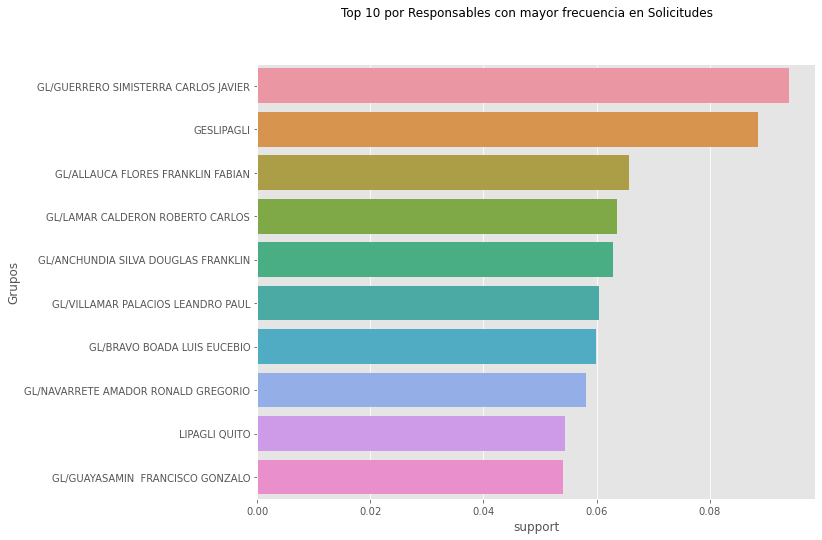

In [9]:
# Grafico
fig,axs = plt.subplots(figsize=(10,8)) 
sns.barplot( data = frequent_itemsets_top, x='support', y='itemsets_cl', orient ="h", 
            order=frequent_itemsets_top.sort_values('support',ascending = False).itemsets_cl)
_=plt.xlabel("support")
_=plt.ylabel("Grupos")
_=plt.suptitle("Top 10 por Responsables con mayor frecuencia en Solicitudes")

### Mayor participacion

In [10]:
## Reglas con mayor participacion de venta.
rules_participacion = association_rules(frequent_itemsets, metric="lift",min_threshold=0.2).sort_values('support',ascending = False)
rules_participacion.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(GL/LAMAR CALDERON ROBERTO CARLOS),(LIPAGLI QUITO),0.063646,0.054481,0.010947,0.172000,3.157084,0.007480,1.141932
2,(GESLIPAGLI),(GL/GUERRERO SIMISTERRA CARLOS JAVIER),0.088595,0.093941,0.010947,0.123563,1.315329,0.002624,1.033799
3,(GL/GUERRERO SIMISTERRA CARLOS JAVIER),(GESLIPAGLI),0.093941,0.088595,0.010947,0.116531,1.315329,0.002624,1.031621
1,(LIPAGLI QUITO),(GL/LAMAR CALDERON ROBERTO CARLOS),0.054481,0.063646,0.010947,0.200935,3.157084,0.007480,1.171812
4,(FLORES SERRANO ERIKA LISSETH),(GL/JIMENEZ ALVAREZ KLEVER GEOVANNI),0.012475,0.047607,0.010692,0.857143,18.004584,0.010099,6.666752


In [11]:
rules_participacion['rules'] = rules_participacion['antecedents'].astype(str) +'-->'+ rules_participacion['consequents'].astype(str)
rules_participacion = rules_participacion.head(10)

In [12]:
rules_participacion['rules'] = rules_participacion['rules'].str.replace("frozenset","", regex=True).str.replace("'","", regex=True).str.replace("{","", regex=True).str.replace("(","", regex=True).str.replace("}","", regex=True).str.replace(")","", regex=True)
rules_participacion.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,rules
0,(GL/LAMAR CALDERON ROBERTO CARLOS),(LIPAGLI QUITO),0.063646,0.054481,0.010947,0.172000,3.157084,0.007480,1.141932,GL/LAMAR CALDERON ROBERTO CARLOS-->LIPAGLI QUITO
2,(GESLIPAGLI),(GL/GUERRERO SIMISTERRA CARLOS JAVIER),0.088595,0.093941,0.010947,0.123563,1.315329,0.002624,1.033799,GESLIPAGLI-->GL/GUERRERO SIMISTERRA CARLOS JAVIER
3,(GL/GUERRERO SIMISTERRA CARLOS JAVIER),(GESLIPAGLI),0.093941,0.088595,0.010947,0.116531,1.315329,0.002624,1.031621,GL/GUERRERO SIMISTERRA CARLOS JAVIER-->GESLIPAGLI
1,(LIPAGLI QUITO),(GL/LAMAR CALDERON ROBERTO CARLOS),0.054481,0.063646,0.010947,0.200935,3.157084,0.007480,1.171812,LIPAGLI QUITO-->GL/LAMAR CALDERON ROBERTO CARLOS
4,(FLORES SERRANO ERIKA LISSETH),(GL/JIMENEZ ALVAREZ KLEVER GEOVANNI),0.012475,0.047607,0.010692,0.857143,18.004584,0.010099,6.666752,FLORES SERRANO ERIKA LISSETH-->GL/JIMENEZ ALVA...


In [13]:
rules_participacion['rules'] = rules_participacion['rules'].str.replace("frozenset","", regex=True).str.replace("'","", regex=True).str.replace("{","", regex=True).str.replace("(","", regex=True).str.replace("}","", regex=True).str.replace(")","", regex=True)
rules_participacion.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,rules
0,(GL/LAMAR CALDERON ROBERTO CARLOS),(LIPAGLI QUITO),0.063646,0.054481,0.010947,0.172000,3.157084,0.007480,1.141932,GL/LAMAR CALDERON ROBERTO CARLOS-->LIPAGLI QUITO
2,(GESLIPAGLI),(GL/GUERRERO SIMISTERRA CARLOS JAVIER),0.088595,0.093941,0.010947,0.123563,1.315329,0.002624,1.033799,GESLIPAGLI-->GL/GUERRERO SIMISTERRA CARLOS JAVIER
3,(GL/GUERRERO SIMISTERRA CARLOS JAVIER),(GESLIPAGLI),0.093941,0.088595,0.010947,0.116531,1.315329,0.002624,1.031621,GL/GUERRERO SIMISTERRA CARLOS JAVIER-->GESLIPAGLI
1,(LIPAGLI QUITO),(GL/LAMAR CALDERON ROBERTO CARLOS),0.054481,0.063646,0.010947,0.200935,3.157084,0.007480,1.171812,LIPAGLI QUITO-->GL/LAMAR CALDERON ROBERTO CARLOS
4,(FLORES SERRANO ERIKA LISSETH),(GL/JIMENEZ ALVAREZ KLEVER GEOVANNI),0.012475,0.047607,0.010692,0.857143,18.004584,0.010099,6.666752,FLORES SERRANO ERIKA LISSETH-->GL/JIMENEZ ALVA...


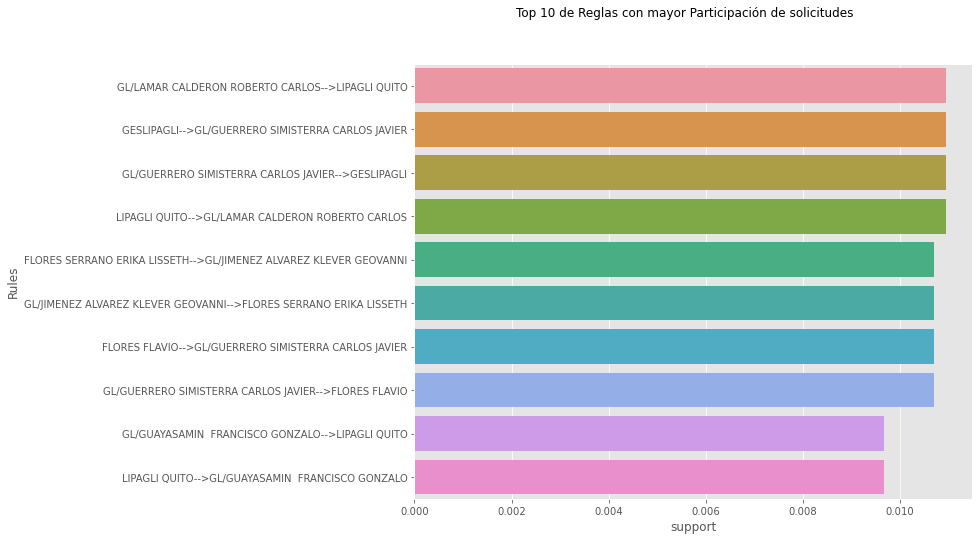

In [14]:
# Grafico
fig,axs = plt.subplots(figsize=(10,8)) 
sns.barplot( data = rules_participacion , x='support', y='rules', orient ="h", 
            order=rules_participacion.sort_values('support',ascending = False).rules)
_=plt.xlabel("support")
_=plt.ylabel("Rules")
_=plt.suptitle("Top 10 de Reglas con mayor Participación de solicitudes")

### Mayor confianza

In [15]:
## Modelo de Reglas de Asociacion (Algoritmo Apriori)
# Reglas con mayor Nro de Confianza.
rules = association_rules(frequent_itemsets, metric="confidence",min_threshold=0.4).sort_values('confidence',ascending = False)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
145,"(TUCTA VARGAS LUISA JANET, FLORES SERRANO ERIK...",(GL/JIMENEZ ALVAREZ KLEVER GEOVANNI),0.001273,0.047607,0.001273,1.0,21.005348,0.001212,inf
240,"(GL/BRAVO BOADA LUIS EUCEBIO, BENAVIDES ROBERTO)",(BARRIONUEVO ZUMARRAGA ANDREA JANIRA),0.001018,0.019348,0.001018,1.0,51.684211,0.000999,inf
260,"(ZURITA MARICELA, GL/MUÑOZ MALAGON JOSE ENRIQUE)",(WILLIAMS GONZALO QUITO LOPEZ),0.001018,0.014511,0.001018,1.0,68.912281,0.001004,inf
167,"(CAICHE PALMA GUILLERMO RAFAEL, GL/MACIAS ZAMB...",(JOSUE DAVID CHAVEZ ESCOBAR),0.001018,0.021385,0.001018,1.0,46.761905,0.000997,inf
172,"(MARIA GABRIELA VALDIVIEZO ROBALINO, GL/CASTRO...",(FLORES FLAVIO),0.001018,0.025204,0.001018,1.0,39.676768,0.000993,inf


In [16]:
#Ordenar cadena en la columna rules
rules['rules'] = rules['antecedents'].astype(str) +' --> '+ rules['consequents'].astype(str)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,rules
145,"(TUCTA VARGAS LUISA JANET, FLORES SERRANO ERIK...",(GL/JIMENEZ ALVAREZ KLEVER GEOVANNI),0.001273,0.047607,0.001273,1.0,21.005348,0.001212,inf,"frozenset({'TUCTA VARGAS LUISA JANET', 'FLORES..."
240,"(GL/BRAVO BOADA LUIS EUCEBIO, BENAVIDES ROBERTO)",(BARRIONUEVO ZUMARRAGA ANDREA JANIRA),0.001018,0.019348,0.001018,1.0,51.684211,0.000999,inf,"frozenset({'GL/BRAVO BOADA LUIS EUCEBIO', 'BEN..."
260,"(ZURITA MARICELA, GL/MUÑOZ MALAGON JOSE ENRIQUE)",(WILLIAMS GONZALO QUITO LOPEZ),0.001018,0.014511,0.001018,1.0,68.912281,0.001004,inf,"frozenset({'ZURITA MARICELA', 'GL/MUÑOZ MALAGO..."
167,"(CAICHE PALMA GUILLERMO RAFAEL, GL/MACIAS ZAMB...",(JOSUE DAVID CHAVEZ ESCOBAR),0.001018,0.021385,0.001018,1.0,46.761905,0.000997,inf,"frozenset({'CAICHE PALMA GUILLERMO RAFAEL', 'G..."
172,"(MARIA GABRIELA VALDIVIEZO ROBALINO, GL/CASTRO...",(FLORES FLAVIO),0.001018,0.025204,0.001018,1.0,39.676768,0.000993,inf,frozenset({'MARIA GABRIELA VALDIVIEZO ROBALINO...


In [17]:
#Eliminar caracteres de la cadena de reglas
rules['rules'] = rules['rules'].str.replace("frozenset","", regex=True).str.replace("'","", regex=True).str.replace("{","", regex=True).str.replace("(","", regex=True).str.replace("}","", regex=True).str.replace(")","", regex=True)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,rules
145,"(TUCTA VARGAS LUISA JANET, FLORES SERRANO ERIK...",(GL/JIMENEZ ALVAREZ KLEVER GEOVANNI),0.001273,0.047607,0.001273,1.0,21.005348,0.001212,inf,"TUCTA VARGAS LUISA JANET, FLORES SERRANO ERIKA..."
240,"(GL/BRAVO BOADA LUIS EUCEBIO, BENAVIDES ROBERTO)",(BARRIONUEVO ZUMARRAGA ANDREA JANIRA),0.001018,0.019348,0.001018,1.0,51.684211,0.000999,inf,"GL/BRAVO BOADA LUIS EUCEBIO, BENAVIDES ROBERTO..."
260,"(ZURITA MARICELA, GL/MUÑOZ MALAGON JOSE ENRIQUE)",(WILLIAMS GONZALO QUITO LOPEZ),0.001018,0.014511,0.001018,1.0,68.912281,0.001004,inf,"ZURITA MARICELA, GL/MUÑOZ MALAGON JOSE ENRIQUE..."
167,"(CAICHE PALMA GUILLERMO RAFAEL, GL/MACIAS ZAMB...",(JOSUE DAVID CHAVEZ ESCOBAR),0.001018,0.021385,0.001018,1.0,46.761905,0.000997,inf,"CAICHE PALMA GUILLERMO RAFAEL, GL/MACIAS ZAMBR..."
172,"(MARIA GABRIELA VALDIVIEZO ROBALINO, GL/CASTRO...",(FLORES FLAVIO),0.001018,0.025204,0.001018,1.0,39.676768,0.000993,inf,"MARIA GABRIELA VALDIVIEZO ROBALINO, GL/CASTRO ..."


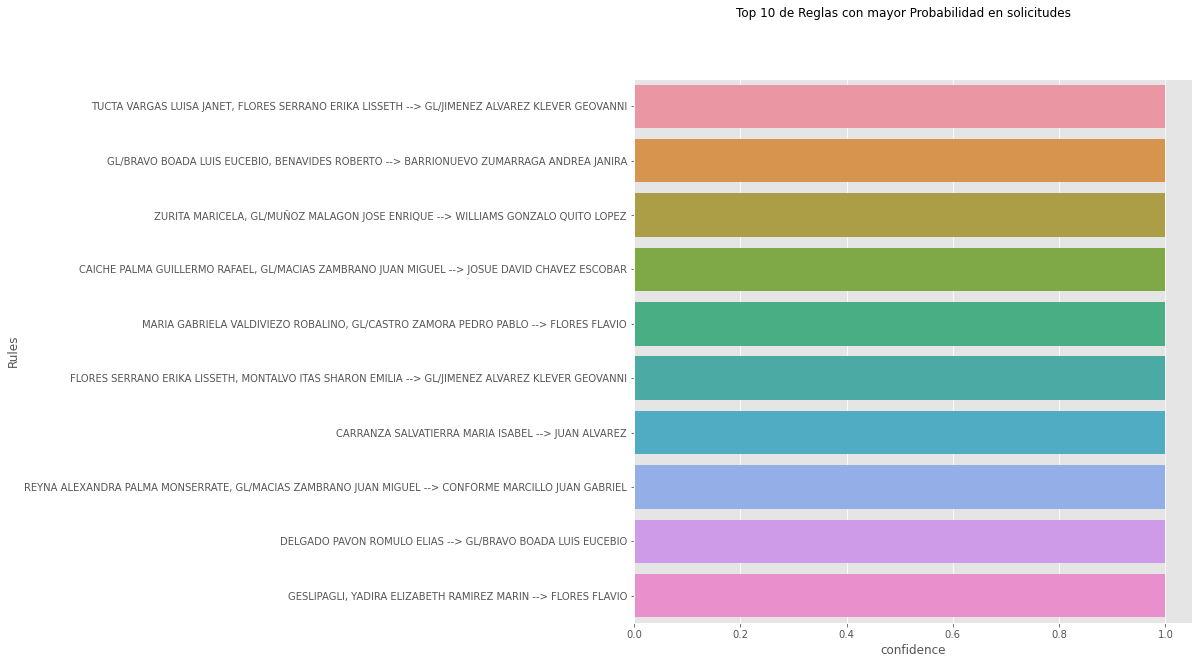

In [18]:
# Grafico
fig,axs = plt.subplots(figsize=(10,10)) 
sns.barplot( data = rules.head(10) , x='confidence', y='rules', orient ="h", 
            order=rules.head(10).sort_values('confidence',ascending = False).rules)
_=plt.xlabel("confidence")
_=plt.ylabel("Rules")
_=plt.suptitle("Top 10 de Reglas con mayor Probabilidad en solicitudes")

### Obtener los más confiables

In [19]:
#filtrado confianza mayor a 0.8
rules_top = rules[rules['confidence']>=0.8] 
rules_top.shape

(34, 10)

In [20]:
# convertir en str (frozenset)
rules_top['consequents']=rules_top['consequents'].astype(str)
rules_top['antecedents']=rules_top['antecedents'].astype(str)

<ipython-input-20-7b560b6820c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-20-7b560b6820c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
#Quita caracteres (frozenset)
rules_top['antecedents'] = rules_top['antecedents'].str.replace("frozenset","", regex=True).str.replace("'","", regex=True).str.replace("{","", regex=True).str.replace("(","", regex=True).str.replace("}","", regex=True).str.replace(")","", regex=True)
rules_top['consequents'] = rules_top['consequents'].str.replace("frozenset","", regex=True).str.replace("'","", regex=True).str.replace("{","", regex=True).str.replace("(","", regex=True).str.replace("}","", regex=True).str.replace(")","", regex=True)
rules_top.head()

<ipython-input-21-2bc1a9fab2dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-21-2bc1a9fab2dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,rules
145,"TUCTA VARGAS LUISA JANET, FLORES SERRANO ERIKA...",GL/JIMENEZ ALVAREZ KLEVER GEOVANNI,0.001273,0.047607,0.001273,1.0,21.005348,0.001212,inf,"TUCTA VARGAS LUISA JANET, FLORES SERRANO ERIKA..."
240,"GL/BRAVO BOADA LUIS EUCEBIO, BENAVIDES ROBERTO",BARRIONUEVO ZUMARRAGA ANDREA JANIRA,0.001018,0.019348,0.001018,1.0,51.684211,0.000999,inf,"GL/BRAVO BOADA LUIS EUCEBIO, BENAVIDES ROBERTO..."
260,"ZURITA MARICELA, GL/MUÑOZ MALAGON JOSE ENRIQUE",WILLIAMS GONZALO QUITO LOPEZ,0.001018,0.014511,0.001018,1.0,68.912281,0.001004,inf,"ZURITA MARICELA, GL/MUÑOZ MALAGON JOSE ENRIQUE..."
167,"CAICHE PALMA GUILLERMO RAFAEL, GL/MACIAS ZAMBR...",JOSUE DAVID CHAVEZ ESCOBAR,0.001018,0.021385,0.001018,1.0,46.761905,0.000997,inf,"CAICHE PALMA GUILLERMO RAFAEL, GL/MACIAS ZAMBR..."
172,"MARIA GABRIELA VALDIVIEZO ROBALINO, GL/CASTRO ...",FLORES FLAVIO,0.001018,0.025204,0.001018,1.0,39.676768,0.000993,inf,"MARIA GABRIELA VALDIVIEZO ROBALINO, GL/CASTRO ..."


rules_top.to_csv('rules01.csv')

### Datasets completo

In [22]:
import pyodbc 
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=SRVDWHBI;'
                      'Database=STAGING;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()
datos = pd.read_sql_query("""SELECT * from staging..TEMP_EIS_RELACION_GESTORES (nolock)
WHERE target = 'Rojo'  
and ciudad in ('GUAYAQUIL','QUITO','GUAYAQUIL-LIPAGLI','QUITO -LIPAGLI')   

""",conn)

In [23]:
rules_top.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,rules
145,"TUCTA VARGAS LUISA JANET, FLORES SERRANO ERIKA...",GL/JIMENEZ ALVAREZ KLEVER GEOVANNI,0.001273,0.047607,0.001273,1.0,21.005348,0.001212,inf,"TUCTA VARGAS LUISA JANET, FLORES SERRANO ERIKA..."
240,"GL/BRAVO BOADA LUIS EUCEBIO, BENAVIDES ROBERTO",BARRIONUEVO ZUMARRAGA ANDREA JANIRA,0.001018,0.019348,0.001018,1.0,51.684211,0.000999,inf,"GL/BRAVO BOADA LUIS EUCEBIO, BENAVIDES ROBERTO..."
260,"ZURITA MARICELA, GL/MUÑOZ MALAGON JOSE ENRIQUE",WILLIAMS GONZALO QUITO LOPEZ,0.001018,0.014511,0.001018,1.0,68.912281,0.001004,inf,"ZURITA MARICELA, GL/MUÑOZ MALAGON JOSE ENRIQUE..."
167,"CAICHE PALMA GUILLERMO RAFAEL, GL/MACIAS ZAMBR...",JOSUE DAVID CHAVEZ ESCOBAR,0.001018,0.021385,0.001018,1.0,46.761905,0.000997,inf,"CAICHE PALMA GUILLERMO RAFAEL, GL/MACIAS ZAMBR..."
172,"MARIA GABRIELA VALDIVIEZO ROBALINO, GL/CASTRO ...",FLORES FLAVIO,0.001018,0.025204,0.001018,1.0,39.676768,0.000993,inf,"MARIA GABRIELA VALDIVIEZO ROBALINO, GL/CASTRO ..."


### SEPARAR A LOS RESPONSABLES

In [24]:
#mapinulacion de las reglas top >0.8
lista = rules_top
#sobreescribir la regla sobreescribe , en vez de -->
lista ['rules'] =   rules_top['antecedents'].astype(str) + "," + rules_top['consequents'].astype(str) 
#separa a los responsables en cada columna
lista =lista["rules"].str.split(',', expand=True)
lista

<ipython-input-24-3b062c00d61d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,0,1,2,3
145,TUCTA VARGAS LUISA JANET,FLORES SERRANO ERIKA LISSETH,GL/JIMENEZ ALVAREZ KLEVER GEOVANNI,None
240,GL/BRAVO BOADA LUIS EUCEBIO,BENAVIDES ROBERTO,BARRIONUEVO ZUMARRAGA ANDREA JANIRA,None
260,ZURITA MARICELA,GL/MUÑOZ MALAGON JOSE ENRIQUE,WILLIAMS GONZALO QUITO LOPEZ,None
167,CAICHE PALMA GUILLERMO RAFAEL,GL/MACIAS ZAMBRANO JUAN MIGUEL,JOSUE DAVID CHAVEZ ESCOBAR,None
172,MARIA GABRIELA VALDIVIEZO ROBALINO,GL/CASTRO ZAMORA PEDRO PABLO,FLORES FLAVIO,None
204,FLORES SERRANO ERIKA LISSETH,MONTALVO ITAS SHARON EMILIA,GL/JIMENEZ ALVAREZ KLEVER GEOVANNI,None
266,CARRANZA SALVATIERRA MARIA ISABEL,JUAN ALVAREZ,None,None
156,REYNA ALEXANDRA PALMA MONSERRATE,GL/MACIAS ZAMBRANO JUAN MIGUEL,CONFORME MARCILLO JUAN GABRIEL,None
268,DELGADO PAVON ROMULO ELIAS,GL/BRAVO BOADA LUIS EUCEBIO,None,None
96,GESLIPAGLI,YADIRA ELIZABETH RAMIREZ MARIN,FLORES FLAVIO,None


In [25]:
# crea lista de los responsables
lista_final =  np.concatenate((lista[0].to_numpy(), lista[1].to_numpy(), lista[2].to_numpy()), axis=0) 
lista_final 

array(['TUCTA VARGAS LUISA JANET', 'GL/BRAVO BOADA LUIS EUCEBIO',
       'ZURITA MARICELA', 'CAICHE PALMA GUILLERMO RAFAEL',
       'MARIA GABRIELA VALDIVIEZO ROBALINO',
       'FLORES SERRANO ERIKA LISSETH',
       'CARRANZA SALVATIERRA MARIA ISABEL',
       'REYNA ALEXANDRA PALMA MONSERRATE', 'DELGADO PAVON ROMULO ELIAS',
       'GESLIPAGLI', 'MARTINEZ HECTOR JOSE',
       'GAVINO ORELLANA ENRIQUE MAURICIO',
       'GONZALEZ MARQUEZ VESALIO RAFAEL',
       'YADIRA ELIZABETH RAMIREZ MARIN',
       'GL/CONSTANTE LITARDO JEFFERSON ANDRES',
       'GRETA ELENA ARRIAGA ASQUI', 'GL/CASTRO ZAMORA PEDRO PABLO',
       'YANEZ NAJERA MERCY JACKELINE',
       'GL/ANCHUNDIA SILVA DOUGLAS FRANKLIN',
       'GL/LADINES DIAZ JIMMY ALEJANDRO', 'TUCTA VARGAS LUISA JANET',
       'JUAN ALVAREZ', 'GL/HENRIQUEZ MOSQUERA HUMBERTO ELIAS',
       'GL/CASTRO ZAMORA PEDRO PABLO', 'ESPINOZA ESPINOZA ALVARO LUIS',
       'FLORES SERRANO ERIKA LISSETH',
       'GL/NAVARRETE AMADOR RONALD GREGORIO', 'REDWOOD ROS

In [26]:
#elimina repetidos de la lista de responsables
def get_unique_list(lista):

    list_of_unique_lista = []

    unique = set(lista)

    for lista in unique :
        list_of_unique_lista.append(lista)

    return list_of_unique_lista 

In [27]:
# ejecuta la funcion que elimina repetidos
lista_final = get_unique_list(lista_final)
lista_final

['GL/NAVARRETE AMADOR RONALD GREGORIO',
 ' KERLY PRISCILA RODRIGUEZ BENAVIDES',
 'KERLY PRISCILA RODRIGUEZ BENAVIDES',
 'GL/CONSTANTE LITARDO JEFFERSON ANDRES',
 ' CONSTANTE ASUNCION',
 'GRETA ELENA ARRIAGA ASQUI',
 'MARTINEZ HECTOR JOSE',
 ' CUESTA MACIAS INGRID KAREN',
 None,
 'RENGIFO CRISTIAN',
 ' WILLIAMS GONZALO QUITO LOPEZ',
 'GL/LAMAR CALDERON ROBERTO CARLOS',
 'FLORES FLAVIO',
 ' JURADO SANISACA CARLOS ALBERTO',
 ' BENAVIDES ROBERTO',
 ' VARGAS LORNA',
 'GONZALEZ MARQUEZ VESALIO RAFAEL',
 ' MONTALVO ITAS SHARON EMILIA',
 'YANEZ NAJERA MERCY JACKELINE',
 ' CARLOS FELIPE ESTRADA YAGUAL',
 'TUCTA VARGAS LUISA JANET',
 ' GL/MACIAS ZAMBRANO JUAN MIGUEL',
 'JUAN ALVAREZ',
 ' FLORES SERRANO ERIKA LISSETH',
 'ACUÑA GABRIEL',
 'JURADO SANISACA CARLOS ALBERTO',
 'MARIA GABRIELA VALDIVIEZO ROBALINO',
 'GL/CASTRO ZAMORA PEDRO PABLO',
 'WILLIAMS GONZALO QUITO LOPEZ',
 'GL/LADINES DIAZ JIMMY ALEJANDRO',
 'CARLOS FELIPE ESTRADA YAGUAL',
 'FLORES SERRANO ERIKA LISSETH',
 'GESLIPAGLI',
 'SUARE

In [28]:
#devuelve los datos del dataframe datos de los emprendedores en la lista
df_emprendedor=datos[datos['emprendedor'].isin(lista_final)]
df_emprendedor

,id_distribuidor,ci_emprendedor,emprendedor,target,des_ejecutivo,des_responsable,des_sponsor,id_solicitud,cod_cliente,ci_cliente,...,respuesta_verificacion_Final,ciudad,factura,fecha_factura,tienda,ciudad_consumo,provincia_consumo,cod_vendedor,ci_vendedor,des_vendedor
0,11032,1722402755,BARRIONUEVO ZUMARRAGA ANDREA JANIRA,Rojo,SUSSAN ZAMBRANO,EDGAR RAMOS,LOPEZ LOPEZ SANDRA EDITH,3454342,1865483,0803870104,...,Verificaciones Correctas,QUITO,01QU00005608,2021-04-18,CALDERON,QUITO,PICHINCHA,550035,1713139895,FARINANGO OSKAR
1,11032,1722402755,BARRIONUEVO ZUMARRAGA ANDREA JANIRA,Rojo,SUSSAN ZAMBRANO,EDGAR RAMOS,LOPEZ LOPEZ SANDRA EDITH,3454342,1865483,0803870104,...,Verificaciones Correctas,QUITO,01QU00005608,2021-04-18,CALDERON,QUITO,PICHINCHA,550035,1713139895,FARINANGO OSKAR
7,11032,1722402755,BARRIONUEVO ZUMARRAGA ANDREA JANIRA,Rojo,SUSSAN ZAMBRANO,EDGAR RAMOS,LOPEZ LOPEZ SANDRA EDITH,3433406,1848189,1313655670,...,Fuera del Perímetro,QUITO,01HC00011551,2021-03-03,EL CARMEN,EL CARMEN,MANABI,271109,1723639017,VILLEGAS ESPINALES ALVARO AGUSTIN
8,4830,0915990584,GRETA ELENA ARRIAGA ASQUI,Rojo,ERICK CUENCA,CINTHIA CUSQUILLO,EMILIA GUADALUPE OLVERA ARGUELLO,3560248,1941017,0926760240,...,Verificaciones Correctas,GUAYAQUIL,01AS00181626,2021-09-11,DURAN,DURAN,GUAYAS,120106,0921161931,CALDERON PINCAY MONICA DIANA
9,4830,0915990584,GRETA ELENA ARRIAGA ASQUI,Rojo,ERICK CUENCA,CINTHIA CUSQUILLO,EMILIA GUADALUPE OLVERA ARGUELLO,3560248,1941017,0926760240,...,No se evidencia documentos,GUAYAQUIL,01AS00181626,2021-09-11,DURAN,DURAN,GUAYAS,120106,0921161931,CALDERON PINCAY MONICA DIANA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9849,11196,1759825258,GONZALEZ MARQUEZ VESALIO RAFAEL,Rojo,SUSSAN ZAMBRANO,EDGAR RAMOS,JESSICA MABEL MORALES IMBAQUINGO,3512584,1884651,1722601984,...,Verificaciones Correctas,QUITO -LIPAGLI,01QW00015003,2021-06-27,PORTAL SHOPPING,QUITO,PICHINCHA,560111,1719203513,YANEZ NAJERA MERCY JACKELINE
9850,11196,1759825258,GONZALEZ MARQUEZ VESALIO RAFAEL,Rojo,SUSSAN ZAMBRANO,EDGAR RAMOS,JESSICA MABEL MORALES IMBAQUINGO,3512584,1884651,1722601984,...,Verificaciones Correctas,QUITO -LIPAGLI,01QW00015003,2021-06-27,PORTAL SHOPPING,QUITO,PICHINCHA,560111,1719203513,YANEZ NAJERA MERCY JACKELINE
9857,11032,1722402755,BARRIONUEVO ZUMARRAGA ANDREA JANIRA,Rojo,SUSSAN ZAMBRANO,EDGAR RAMOS,LOPEZ LOPEZ SANDRA EDITH,3520567,1887234,1715201669,...,Verificaciones Correctas,QUITO -LIPAGLI,01QW00015748,2021-07-16,PORTAL SHOPPING,QUITO,PICHINCHA,570152,1723734487,VALENCIA RAUL
9858,11032,1722402755,BARRIONUEVO ZUMARRAGA ANDREA JANIRA,Rojo,SUSSAN ZAMBRANO,EDGAR RAMOS,LOPEZ LOPEZ SANDRA EDITH,3520567,1887234,1715201669,...,Verificaciones Correctas,QUITO -LIPAGLI,01QW00015748,2021-07-16,PORTAL SHOPPING,QUITO,PICHINCHA,570152,1723734487,VALENCIA RAUL


In [29]:
#devuelve los datos del dataframe datos de los verificador terreno en la lista
df_verificador_terreno=datos[datos['verificador_terreno'].isin(lista_final)]

In [30]:
df_vendedor=datos[datos['des_vendedor'].isin(lista_final)]

In [31]:
df_vendedor.to_csv('rules_vend.csv')

In [ ]:
df_emprendedor.to_csv('rules_emp.csv')

In [ ]:
df_verificador_terreno.to_csv('rules_vt.csv')

### Agrupados de responsables por ciudad y tienda

In [ ]:
solicitudes = df_emprendedor.groupby(['ciudad_consumo','tienda'])["id_solicitud"].count().reset_index()

# GRAFICO
sns.barplot( data = solicitudes, x="id_solicitud", y="tienda", orient ="h", 
            order=solicitudes.sort_values('id_solicitud',ascending = False).tienda[:10])
_=plt.xlabel("Cantidad de Solicitudes")
_=plt.ylabel("Tienda") 
_=plt.suptitle("Top 10 de Tiendas")

In [ ]:
solicitudes = df_verificador_terreno.groupby(['ciudad_consumo','tienda'])["id_solicitud"].count().reset_index()

# GRAFICO
sns.barplot( data = solicitudes, x="id_solicitud", y="tienda", orient ="h", 
            order=solicitudes.sort_values('id_solicitud',ascending = False).tienda[:10])
_=plt.xlabel("Cantidad de Solicitudes")
_=plt.ylabel("Tienda") 
_=plt.suptitle("Top 10 de Tiendas")